In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-04-10 09:31:11.415521: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 09:31:11.868538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 09:31:11.868583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 09:31:11.940627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 09:31:12.086810: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 09:31:12.088617: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

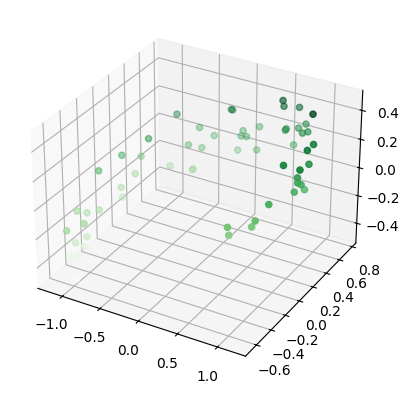

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-04-10 09:31:15.599102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 09:31:15.783639: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 5ms/step - loss: 0.3191
Epoch 2/30
2/2 [==============================] - 0s 3ms/step - loss: 0.3109
Epoch 3/30
2/2 [==============================] - 0s 4ms/step - loss: 0.3033
Epoch 4/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2961
Epoch 5/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2894
Epoch 6/30
2/2 [==============================] - 0s 3ms/step - loss: 0.2831
Epoch 7/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2772
Epoch 8/30
2/2 [==============================] - 0s 5ms/step - loss: 0.2718
Epoch 9/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2665
Epoch 10/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2618
Epoch 11/30
2/2 [==============================] - 0s 5ms/step - loss: 0.2568
Epoch 12/30
2/2 [==============================] - 0s 4ms/step - loss: 0.2523
Epoch 13/30
2/2 [==============================] - 0s 4ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


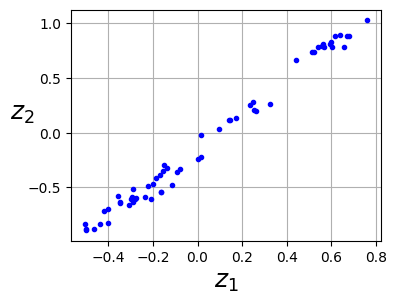

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3395 - rounded_accuracy: 0.8859 - val_loss: 0.3111 - val_rounded_accuracy: 0.9114
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3072 - rounded_accuracy: 0.9138 - val_loss: 0.3034 - val_rounded_accuracy: 0.9199
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3005 - rounded_accuracy: 0.9197 - val_loss: 0.2974 - val_rounded_accuracy: 0.9216
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2964 - rounded_accuracy: 0.9235 - val_loss: 0.2943 - val_rounded_accuracy: 0.9264
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2936 - rounded_accuracy: 0.9260 - val_loss: 0.2954 - val_rounded_accuracy: 0.9201
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2918 - rounded_accuracy: 0.9276 - val_loss: 0.2903 - val_rounded_accuracy: 0.9286
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, images=X_val, n_images=5):
    true_images = images[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 0s 860us/step


In [15]:
# plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')

### Tying Weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer="zeros")        
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
        

In [17]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3308 - rounded_accuracy: 0.8920 - val_loss: 0.3018 - val_rounded_accuracy: 0.9208
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2983 - rounded_accuracy: 0.9215 - val_loss: 0.2938 - val_rounded_accuracy: 0.9244
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2908 - val_rounded_accuracy: 0.9266
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9302 - val_loss: 0.2872 - val_rounded_accuracy: 0.9319
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2871 - rounded_accuracy: 0.9321 - val_loss: 0.2939 - val_rounded_accuracy: 0.9171
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2856 - rounded_accuracy: 0.9334 - val_loss: 0.2845 - val_rounded_accuracy: 0.9344
Epoch 7/10
1500/1500 [==================

In [18]:
# show_reconstructions(tied_ae)
# plt.show()

### CNN Autoencoder

In [19]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [20]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [21]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_val, X_val])

Epoch 1/5
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3054 - rounded_accuracy: 0.9161 - val_loss: 0.2794 - val_rounded_accuracy: 0.9403
Epoch 2/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2776 - rounded_accuracy: 0.9396 - val_loss: 0.2728 - val_rounded_accuracy: 0.9451
Epoch 3/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2725 - rounded_accuracy: 0.9446 - val_loss: 0.2697 - val_rounded_accuracy: 0.9482
Epoch 4/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2698 - rounded_accuracy: 0.9474 - val_loss: 0.2677 - val_rounded_accuracy: 0.9507
Epoch 5/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2680 - rounded_accuracy: 0.9494 - val_loss: 0.2672 - val_rounded_accuracy: 0.9512


1/1 [==============================] - 0s 82ms/step


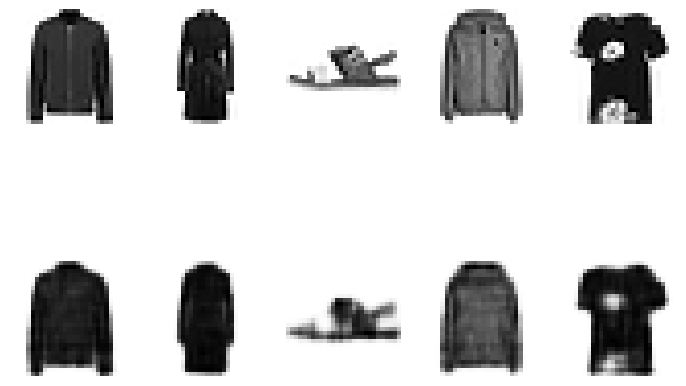

In [22]:
show_reconstructions(conv_ae)

In [23]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

### RNN Autoencoder

In [24]:
rnn_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),
    keras.layers.LSTM(30)
])
rnn_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

In [25]:
rnn_ae = keras.models.Sequential([rnn_encoder, rnn_decoder])


### Denoising Autoencoder

In [26]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
denoise_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'), 
    keras.layers.Reshape([28,28])
])

In [27]:
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])
denoise_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = denoise_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3630 - rounded_accuracy: 0.8655 - val_loss: 0.3226 - val_rounded_accuracy: 0.9027
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3218 - rounded_accuracy: 0.9005 - val_loss: 0.3125 - val_rounded_accuracy: 0.9094
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3154 - rounded_accuracy: 0.9052 - val_loss: 0.3087 - val_rounded_accuracy: 0.9135
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3115 - rounded_accuracy: 0.9085 - val_loss: 0.3045 - val_rounded_accuracy: 0.9165
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3085 - rounded_accuracy: 0.9106 - val_loss: 0.3019 - val_rounded_accuracy: 0.9176
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9127 - val_loss: 0.2998 - val_rounded_accuracy: 0.9202
Epoch 7/10
1500/1500 [==================

In [28]:
# show_reconstructions(denoise_ae)

(-0.5, 27.5, 27.5, -0.5)

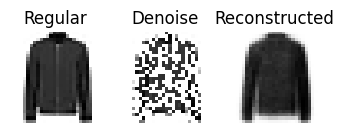

In [29]:
dropout = keras.layers.Dropout(0.5)
figure = plt.figure(figsize=[4,3])
figure.add_subplot(1,3,1)
plt.imshow(X_val[0], cmap='binary')
plt.title('Regular')
plt.axis('off')
figure.add_subplot(1,3,2)
plt.imshow(dropout(X_val[0], training=True), cmap='binary')
plt.title('Denoise')
plt.axis('off')
figure.add_subplot(1,3,3)
plt.imshow(denoise_ae(dropout(X_val))[0], cmap='binary')
plt.title('Reconstructed')
plt.axis('off')

### Sparse Autoencoder

In [30]:
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-3))
])

sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [31]:
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])
sparse_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = sparse_ae.fit(X_train, X_train, epochs=20, validation_data=(X_val, X_val))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4399 - rounded_accuracy: 0.8060 - val_loss: 0.3813 - val_rounded_accuracy: 0.8567
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3726 - rounded_accuracy: 0.8662 - val_loss: 0.3653 - val_rounded_accuracy: 0.8733
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3611 - rounded_accuracy: 0.8749 - val_loss: 0.3561 - val_rounded_accuracy: 0.8774
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3509 - rounded_accuracy: 0.8823 - val_loss: 0.3459 - val_rounded_accuracy: 0.8845
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3426 - rounded_accuracy: 0.8884 - val_loss: 0.3402 - val_rounded_accuracy: 0.8908
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3369 - rounded_accuracy: 0.8928 - val_loss: 0.3339 - val_rounded_accuracy: 0.8959
Epoch 7/20
1500/1500 [==================

### Variational Autoencoders

In [32]:
import keras.backend as K

In [33]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_sigma = inputs
        epsilon = keras.backend.random_normal(tf.shape(z_sigma))
        return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [34]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])


# KL_divergence=−0.5×∑i=1N​(1+log(σi2​)−μi2​−σi2​)
# Because we interpret the output as the logarithm of the variance.
# in the kl_div below we exponent the log of variance to get clean variance
kl_divergence = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)
variational_ae.add_loss(keras.backend.mean(kl_divergence) / 784.)
variational_ae.compile(loss="mse", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))


Epoch 1/25
375/375 [==============================] - 3s 7ms/step - loss: 0.0805 - rounded_accuracy: 0.7900 - val_loss: 0.0601 - val_rounded_accuracy: 0.8418
Epoch 2/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0552 - rounded_accuracy: 0.8556 - val_loss: 0.0527 - val_rounded_accuracy: 0.8688
Epoch 3/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0492 - rounded_accuracy: 0.8705 - val_loss: 0.0475 - val_rounded_accuracy: 0.8685
Epoch 4/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0450 - rounded_accuracy: 0.8810 - val_loss: 0.0431 - val_rounded_accuracy: 0.8895
Epoch 5/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0426 - rounded_accuracy: 0.8863 - val_loss: 0.0426 - val_rounded_accuracy: 0.8922
Epoch 6/25
375/375 [==============================] - 2s 6ms/step - loss: 0.0411 - rounded_accuracy: 0.8896 - val_loss: 0.0405 - val_rounded_accuracy: 0.8892
Epoch 7/25
375/375 [==============================] 

In [35]:
print(variational_encoder.summary())
print(variational_decoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten_4 (Flatten)         (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense_17 (Dense)            (None, 150)                  117750    ['flatten_4[0][0]']           
                                                                                                  
 dense_18 (Dense)            (None, 100)                  15100     ['dense_17[0][0]']            
                                                                                              

In [36]:
codings = tf.random.normal(shape=[12, 10])
print(codings)

tf.Tensor(
[[-4.8536450e-01 -1.5497299e-01 -3.0977526e+00 -4.9823052e-03
  -1.7856570e-01  1.4329706e+00  4.7644889e-01 -3.2347158e-01
  -2.6835766e-01  5.6609416e-01]
 [ 2.0028827e+00  1.1435255e+00 -1.7807159e+00 -8.8168263e-01
   1.9795302e+00 -1.1952689e+00 -1.7168078e+00  6.4083195e-01
   1.3944621e-01 -9.3646950e-01]
 [-5.2102983e-01  5.2093780e-01  3.7935725e-01  3.7642148e-01
   5.0456095e-01  7.9130059e-01  5.0012350e-01  7.9158908e-01
   5.8237278e-01 -5.4091609e-01]
 [-1.7175705e+00  7.9010981e-01 -8.1871378e-01 -1.1105274e+00
  -8.8498324e-02 -1.6232048e+00  5.4997750e-02  8.3289319e-01
   3.8180548e-01 -5.2356130e-01]
 [-7.8787082e-01  1.3737371e+00 -5.3019178e-01  1.5034927e-01
   4.6210635e-01 -7.6005691e-01  1.9549612e+00 -4.0986639e-01
  -1.4038239e+00 -9.1120768e-01]
 [ 4.5981613e-01  2.8514462e+00  2.0616163e-04 -9.4956392e-01
  -1.0367749e-02 -1.1637294e+00 -5.9640706e-01  1.7057877e+00
   1.2181934e+00  3.8457397e-01]
 [-2.3991320e+00  6.8197125e-01 -7.8263712e-01 

In [37]:
reconstructions = variational_decoder(codings).numpy()
def plot_multiple_images(images, n_columns=None):
    n_images = images.shape[0]
    n_columns = n_columns or len(images)
    n_rows =  n_images // n_columns + 1
    figure = plt.figure(figsize=[4,3])
    for i, image in enumerate(images):
        figure.add_subplot(n_rows, n_columns, i + 1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

In [38]:
# plot_multiple_images(reconstructions, n_columns=4)

### Generative Adversarial Networks (GANS)

In [39]:
keras.backend.clear_session()

In [40]:
codings_dim = 20

generator = keras.models.Sequential([
    keras.layers.Input(shape=[codings_dim]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [41]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [43]:
def train_gan(gan, dataset, batch_size, codings_dim, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for batch in dataset:
            # Phase 1 -> training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_dim])
            fake_images = generator(noise)
            X = tf.concat([batch, fake_images], axis=0)
            Y = tf.constant([[1]] * batch_size + [[0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X, Y)
            # Phase 2 -> training the generator
            noise = tf.random.normal(shape=[batch_size, codings_dim])
            y = tf.constant([[1]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y)
        plot_multiple_images(fake_images, 8)
        plt.show()

In [44]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(48000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

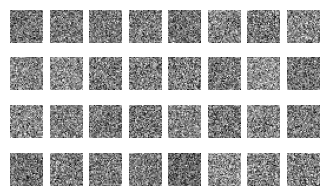

In [45]:
# Before training
noise = tf.random.normal(shape=[batch_size, 20])
plot_multiple_images(generator(noise), 8)

Epoch 1/1


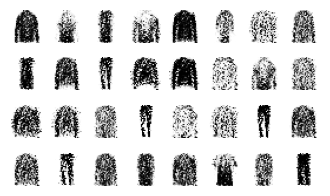

In [46]:
# 1 Training epoch
train_gan(gan, dataset, 32, 20, 1)

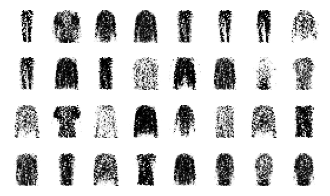

In [47]:
# After training for 1 epoch
noise = tf.random.normal(shape=[batch_size, 20])
plot_multiple_images(generator(noise), 8)

Epoch 1/50


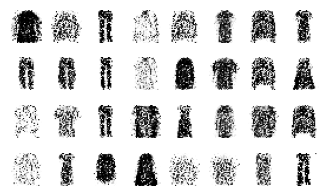

Epoch 2/50


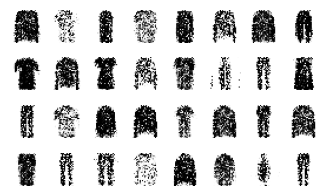

Epoch 3/50


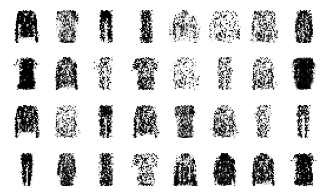

Epoch 4/50


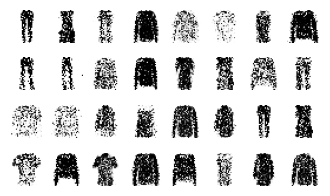

Epoch 5/50


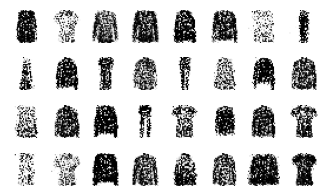

Epoch 6/50


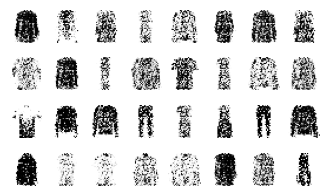

Epoch 7/50


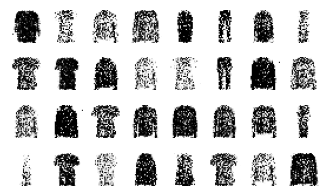

Epoch 8/50


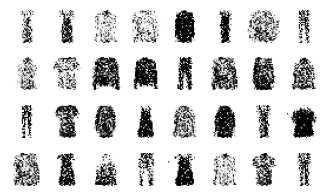

Epoch 9/50


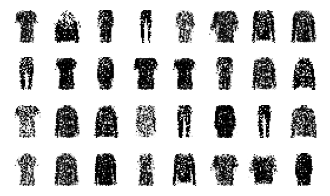

Epoch 10/50


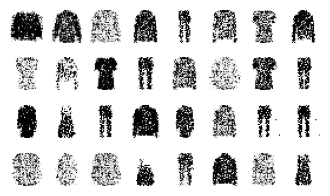

Epoch 11/50


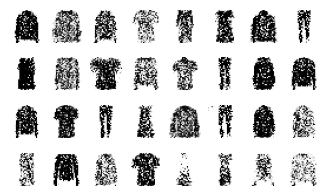

Epoch 12/50


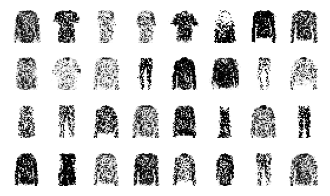

Epoch 13/50


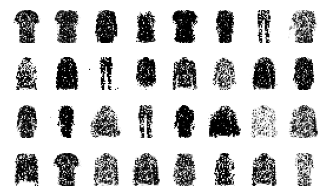

Epoch 14/50


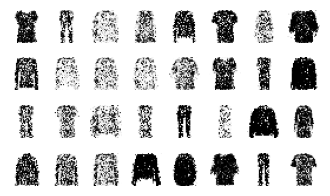

Epoch 15/50


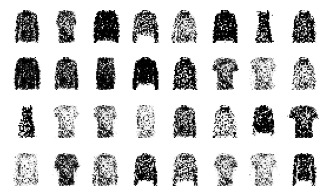

Epoch 16/50


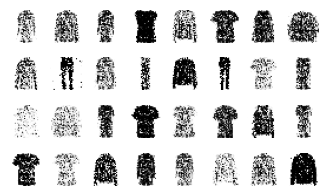

Epoch 17/50


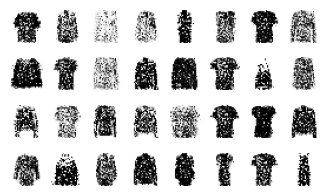

Epoch 18/50


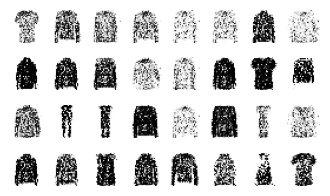

Epoch 19/50


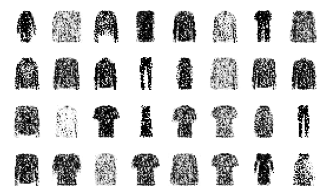

Epoch 20/50


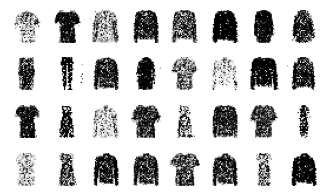

Epoch 21/50


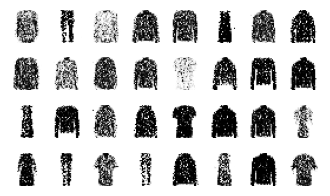

Epoch 22/50


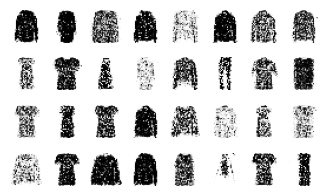

Epoch 23/50


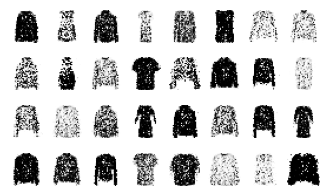

Epoch 24/50


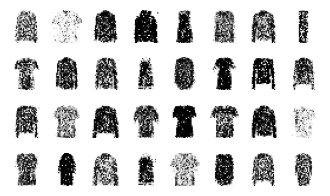

Epoch 25/50


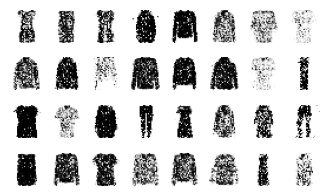

Epoch 26/50


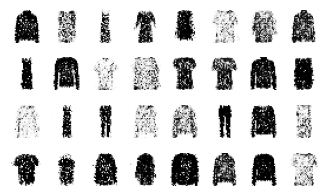

Epoch 27/50


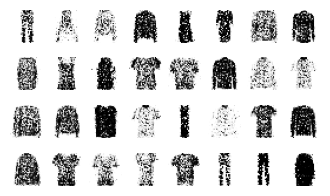

Epoch 28/50


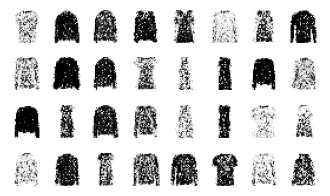

Epoch 29/50


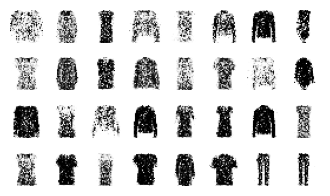

Epoch 30/50


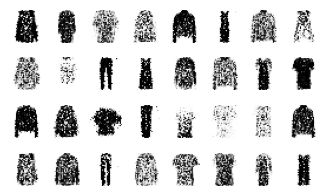

Epoch 31/50


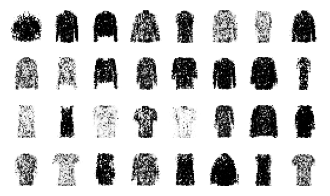

Epoch 32/50


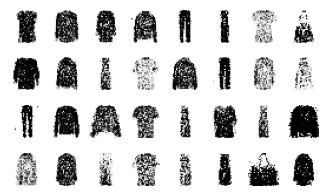

Epoch 33/50


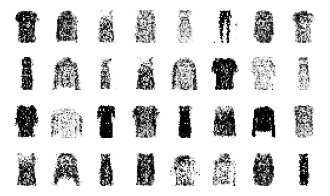

Epoch 34/50


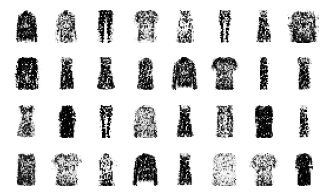

Epoch 35/50


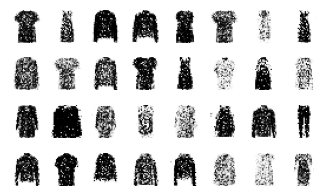

Epoch 36/50


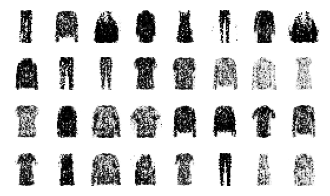

Epoch 37/50


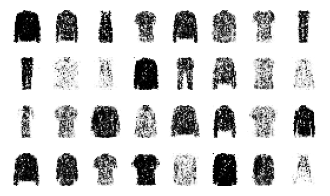

Epoch 38/50


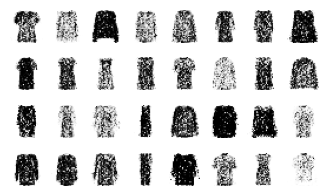

Epoch 39/50


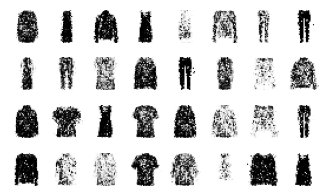

Epoch 40/50


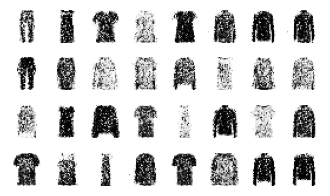

Epoch 41/50


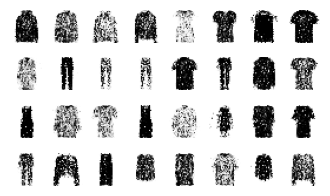

Epoch 42/50


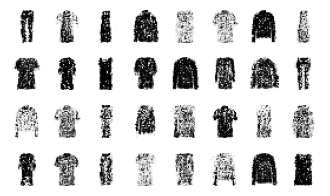

Epoch 43/50


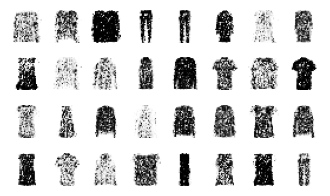

Epoch 44/50


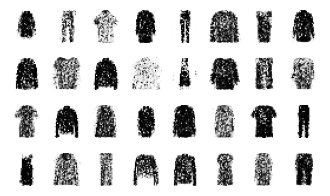

Epoch 45/50


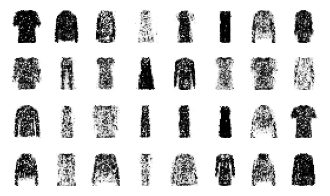

Epoch 46/50


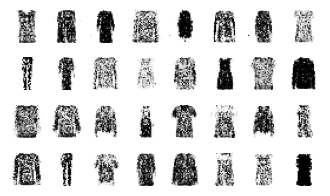

Epoch 47/50


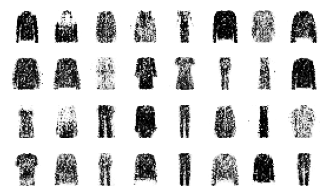

Epoch 48/50


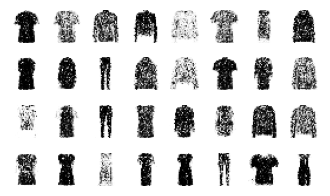

Epoch 49/50


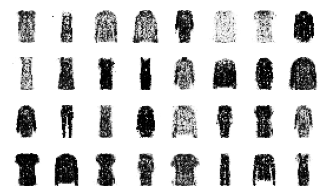

Epoch 50/50


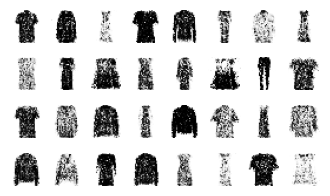

In [48]:
train_gan(gan, dataset, 32, 20, 50)

In [49]:
exmp = np.array([[[[1.],[2.],[3.]],[[1.],[2.],[3.]],[[1.],[2.],[3.]]]])

In [50]:
exmp.shape

(1, 3, 3, 1)

In [51]:
keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2)(exmp)

<tf.Tensor: shape=(1, 7, 7, 3), dtype=float32, numpy=
array([[[[ 0.23932654,  0.13265902,  0.32088083],
         [ 0.1565013 ,  0.15743577,  0.32480836],
         [ 0.61648774,  0.04994762,  1.0491192 ],
         [ 0.3130026 ,  0.31487155,  0.6496167 ],
         [ 0.99364895, -0.03276378,  1.7773576 ],
         [ 0.46950388,  0.47230732,  0.9744251 ],
         [ 0.413504  , -0.64611125,  1.2220727 ]],

        [[ 0.1545906 ,  0.15556091,  0.0545623 ],
         [ 0.05798867, -0.36023423,  0.2680028 ],
         [ 0.5446551 ,  0.6719326 ,  0.42940116],
         [ 0.11597735, -0.72046846,  0.5360056 ],
         [ 0.93471956,  1.1883042 ,  0.80424   ],
         [ 0.17396602, -1.0807027 ,  0.8040084 ],
         [ 0.7064216 ,  1.0824323 ,  0.9608297 ]],

        [[ 0.5859454 ,  0.3548907 ,  0.55783975],
         [-0.12229496,  0.06323671,  0.7145569 ],
         [ 0.94966114,  0.42561272,  1.1790702 ],
         [-0.24458992,  0.12647343,  1.4291137 ],
         [ 1.3133769 ,  0.49633473,  1.800

### Conv GANS

In [ ]:
keras.backend.clear_session()

codings_dim = 100

generator = keras.models.Sequential([
    keras.layers.Input(shape=[coding_dim]),
    keras.layers.
])

discriminator = keras.models.Sequential([
    
])